In [4]:
import numpy as np
import scipy.sparse as sp
import os
import csv

def get_binned_burst_info(dataset_name, output_folder=None):
    """
    Identify bursts using binned spike count data stored as a sparse matrix (NPZ file)
    and save burst information to a CSV file.
    
    Assumptions:
      - The NPZ file contains a sparse matrix with dimensions (n_neurons x n_bins)
        representing spike counts per 10ms bin for each neuron.
      - Burst detection threshold: 0.5 spikes/sec/neuron.
        For 10ms bins (0.01 sec), threshold = 0.5 * 0.01 = 0.005 spikes/neuron/bin.
    
    Burst info includes:
      ID, startBin#, endBin#, width (bins), totalSpikeCount, peakBin,
      peakHeight (spikes), Interval (bins)
    
    Parameters:
      dataset_name (str): Name/path of the dataset (without extension). e.g. 'tR_1.0--fE_0.90_10000'
      npz_filename (str, optional): Full path to NPZ file. If None, defaults to dataset_name+'.npz'
      output_folder (str, optional): Folder to save CSV file. If None, use dataset_name.
    """
    
    # Set defaults if not provided
    # if npz_filename is None:
    #     npz_filename = dataset_name + '.npz'
    if output_folder is None:
        output_folder = dataset_name
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # Load the sparse spike count matrix from the NPZ file.
    try:
        sparse_spike_counts = sp.load_npz('/home/NETID/hdhanu/GNN/Burst_Data/spike_matrix_sparse.npz')
    except Exception as e:
        raise IOError(f"Error loading NPZ file {npz_filename}: {e}")
    
    # Get the dimensions (n_neurons, n_bins)
    n_neurons, n_bins = sparse_spike_counts.shape
    print(f"Loaded spike counts: {n_neurons} neurons, {n_bins} time bins.")
    
    # Aggregate spike counts per bin across all neurons using sparse sum.
    # This returns a matrix; convert to a 1D dense array.
    spikes_per_bin_sparse = sparse_spike_counts.sum(axis=0)  # shape: (1, n_bins)
    spikes_per_bin = np.array(spikes_per_bin_sparse).ravel()  # now a vector of length n_bins
    
    # Compute spike count per neuron per bin.
    spikes_per_neuron_per_bin = spikes_per_bin / n_neurons  # vector of length n_bins
    
    # Each bin is 10ms (0.01 seconds)
    bin_width = 0.01  # seconds
    adjusted_burst_threshold = 0.5 * bin_width  # = 0.005 spikes/neuron/bin
    print(f"Adjusted burst threshold: {adjusted_burst_threshold} spikes/neuron/bin")
    
    # Identify bins where per-neuron spike count >= threshold.
    bins_above_threshold = np.where(spikes_per_neuron_per_bin >= adjusted_burst_threshold)[0]
    print(f"Found {len(bins_above_threshold)} bins above threshold.")
    
    # Identify burst boundaries: a new burst starts if bins are not consecutive.
    diff_bins = np.diff(bins_above_threshold)
    burst_boundaries = np.where(diff_bins > 1)[0]  # indices in bins_above_threshold where gap occurs
    n_bursts = len(burst_boundaries) + 1
    print(f"Detected {n_bursts} bursts.")
    
    # For convenience, add boundaries at start and end.
    burst_boundaries = np.concatenate(([0], burst_boundaries, [len(bins_above_threshold)]))

   # Open CSV for writing burst info.
    output_csv = os.path.join(output_folder, 'allBinnedBurstInfo.csv')
    with open(output_csv, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        # Write header
        csv_writer.writerow(['ID', 'startBin#', 'endBin#', 'width(bins)', 'totalSpikeCount',
                             'peakBin', 'peakHeight(spikes)', 'Interval(bins)'])
        
        previous_peak = 0
        # Loop through each detected burst.
        for iBurst in range(n_bursts):
            start_idx = burst_boundaries[iBurst]
            end_idx = burst_boundaries[iBurst + 1] - 1  # inclusive index in bins_above_threshold
            
            start_bin_num = bins_above_threshold[start_idx]
            end_bin_num = bins_above_threshold[end_idx]
            
            width = (end_bin_num - start_bin_num) + 1  # burst width in bins
            total_spike_count = np.sum(spikes_per_bin[start_bin_num:end_bin_num+1])
            
            # Find the peak (max spike count) within the burst interval.
            burst_bins = spikes_per_bin[start_bin_num:end_bin_num+1]
            peak_height = np.max(burst_bins)
            peak_height_index = np.argmax(burst_bins)
            peak_bin = start_bin_num + peak_height_index
            
            burst_interval = peak_bin - previous_peak
            csv_writer.writerow([iBurst + 1, start_bin_num, end_bin_num, width,
                                 int(total_spike_count), peak_bin, int(peak_height), burst_interval])
            
            previous_peak = peak_bin
            
    print(f"Burst information saved to {output_csv}")

# Example usage:
if __name__ == '__main__':
    dataset_name = '/home/NETID/hdhanu/GNN/Burst_Data/spike_matrix_sparse.npz'
    output_folder = os.path.join(os.path.dirname(dataset_name), 'output')
    os.makedirs(output_folder, exist_ok=True)
    get_binned_burst_info(dataset_name, output_folder)


Loaded spike counts: 10000 neurons, 6000000 time bins.
Adjusted burst threshold: 0.005 spikes/neuron/bin
Found 153321 bins above threshold.
Detected 9164 bursts.
Burst information saved to /home/NETID/hdhanu/GNN/Burst_Data/output/allBinnedBurstInfo.csv


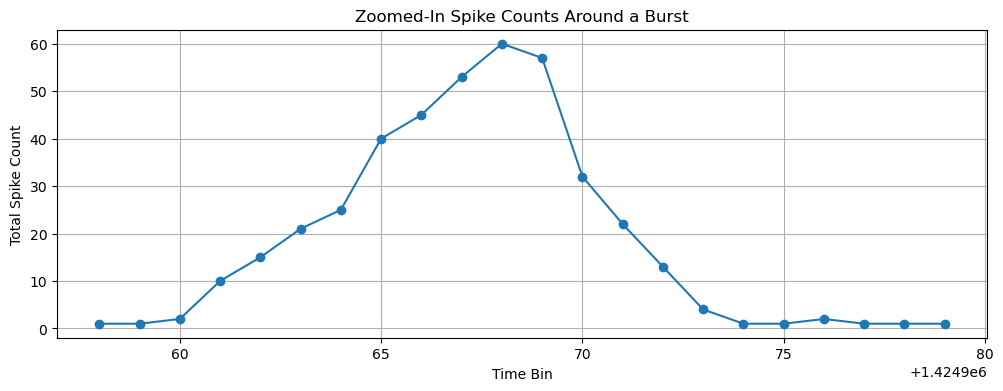

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sp

# Load your spike history array (assumed to be in a .npy file)
spikesPerBin = np.load('/DATA/hdhanu/GNN/Burst_Data/output/spikesHistory_1.0_0.90.npy').astype(np.float64)

# Choose a region around a burst—for example, bins 1004083 to 1004120.
start_bin = 1424968 - 10
end_bin = 1424970 + 10
plt.figure(figsize=(12, 4))
plt.plot(np.arange(start_bin, end_bin), spikesPerBin[start_bin:end_bin], '-o')
plt.xlabel('Time Bin')
plt.ylabel('Total Spike Count')
plt.title('Zoomed-In Spike Counts Around a Burst')
plt.grid(True)
plt.show()


In [3]:
import os
import h5py
import numpy as np
import csv

def get_binned_burst_info(dataset_name):
    """
    Identify bursts using binned spike count data and save burst information to a CSV file.
    
    Assumptions:
      - The HDF5 file <dataset_name>.h5 contains a dataset '/neuronTypes'
        whose Dataspace size gives the number of neurons.
      - The spike history is stored in a separate NumPy file 'spikesHistory.npy' in the same folder.
      - Each bin is 10ms (0.01 s).
      - The detection threshold is set to 0.5 spikes/sec/neuron which for 10ms bins 
        equals 0.5*0.01 = 0.005 spikes/neuron/bin.
    
    The CSV output contains:
         ID, startBin#, endBin#, width(bins), totalSpikeCount, peakBin, peakHeight(spikes), Interval(bins)
    """
    # Build full file paths.
    h5_filepath = '/DATA/hdhanu/GNN/Burst_Data/tR_1.0--fE_0.98_10000.h5'
    # base_dir = os.path.dirname(dataset_name)
    output_folder = '/DATA/hdhanu/GNN/Burst_Data/output'
    os.makedirs(output_folder, exist_ok=True)
    output_csv = os.path.join(output_folder, 'allBinnedBurstInfo_python.csv')
    print('Build file paths')
    # --- Get number of neurons from the /neuronTypes dataset ---
    with h5py.File(h5_filepath, 'r') as f:
        # Get all neuron datasets (assume names start with "Neuron_")
        neuron_keys = [key for key in f.keys() if key.startswith("Neuron_")]
        if not neuron_keys:
            raise ValueError("No neuron datasets found in the file.")
        neuron_keys.sort()  # Ensure consistent order
        nNeurons = len(neuron_keys)  # assuming neuronTypes is a 1D array or its first dimension corresponds to number of neurons
        print('Loaded Neuron datasets from HDF5')
        print(nNeurons)

    # --- Load the spike history from an npy file ---
    base_dir = '/DATA/hdhanu/GNN/Burst_Data'
    spikesHistory_path = os.path.join(base_dir, 'spikesHistory.npy')
    spikesPerBin = np.load(spikesHistory_path).astype(np.float64)
    print(f"Loaded spike counts: nNeurons assumed {nNeurons}, nBins = {spikesPerBin.shape[0]}")
    
    # Compute per-neuron spike count per bin.
    spikesPerNeuronPerBin = spikesPerBin / nNeurons
    print('spikesPerNeuronPerBin', spikesPerNeuronPerBin)
    
    # Set the adjusted burst threshold: 0.5 spikes/sec/neuron for 10ms bins → 0.5*0.01 = 0.005
    adjustedBurstThreshold = 0.005
    print(f"Adjusted burst threshold: {adjustedBurstThreshold} spikes/neuron/bin")
    
    # Find indices of bins above the threshold.
    binsAboveThreshold = np.where(spikesPerNeuronPerBin >= adjustedBurstThreshold)[0]
    print(f"Found {len(binsAboveThreshold)} bins above threshold.")
    
    # Identify burst boundaries: a new burst starts if consecutive bins are not sequential.
    diff_bins = np.diff(binsAboveThreshold)
    burstBoundaryIndices = np.where(diff_bins > 1)[0]  # indices in binsAboveThreshold where there is a gap.
    nBursts = len(burstBoundaryIndices) + 1
    print(f"Detected {nBursts} bursts.")
    
    # Add boundary markers at start and end.
    burst_boundaries = np.concatenate(([0], burstBoundaryIndices, [len(binsAboveThreshold)]))
    
    previous_peak = 0

    # Open CSV file for writing.
    with open(output_csv, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        # Write header.
        csv_writer.writerow(['ID', 'startBin#', 'endBin#', 'width(bins)', 'totalSpikeCount',
                             'peakBin', 'peakHeight(spikes)', 'Interval(bins)'])
        for iBurst in range(nBursts):
            start_idx = burst_boundaries[iBurst]
            end_idx = burst_boundaries[iBurst + 1] - 1  # inclusive index
            start_bin_num = binsAboveThreshold[start_idx]
            end_bin_num = binsAboveThreshold[end_idx]
            width = (end_bin_num - start_bin_num) + 1  # burst width in bins
            totalSpikeCount = int(np.sum(spikesPerBin[start_bin_num:end_bin_num + 1]))
            
            # Determine the peak: find the bin within this burst interval with the maximum spike count.
            burst_bins = spikesPerBin[start_bin_num:end_bin_num + 1]
            peakHeight = int(np.max(burst_bins))
            peakHeightIndex = int(np.argmax(burst_bins))
            peakBin = start_bin_num + peakHeightIndex
            
            burstInterval = peakBin - previous_peak
            csv_writer.writerow([iBurst + 1, start_bin_num, end_bin_num, width,
                                 totalSpikeCount, peakBin, peakHeight, burstInterval])
            previous_peak = peakBin

    print(f"Burst information saved to {output_csv}")

# Example usage:
if __name__ == '__main__':
    # Replace the dataset_name with your actual dataset file path (without the .h5 extension)
    dataset_name = '/DATA/hdhanu/GNN/Burst_Data/Burst_Data/spikesHistory.npy'
    get_binned_burst_info(dataset_name)


Build file paths
Loaded Neuron datasets from HDF5
10000
Loaded spike counts: nNeurons assumed 10000, nBins = 6000000
spikesPerNeuronPerBin [0.     0.     0.     ... 0.0001 0.0001 0.0001]
Adjusted burst threshold: 0.005 spikes/neuron/bin
Found 28397 bins above threshold.
Detected 8841 bursts.
Burst information saved to /DATA/hdhanu/GNN/Burst_Data/output/allBinnedBurstInfo_python.csv


In [4]:
import numpy as np
import scipy.io as sio

# Load the numpy file
spikesPerBin = np.load('/DATA/hdhanu/GNN/Burst_Data/output/spikesHistory_1.0_0.90.npy')

# Save it as a MATLAB .mat file
sio.savemat('spikesHistory_1.0_0.90.mat', {'spikesPerBin': spikesPerBin})